In [2]:
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold, StratifiedKFold
import matplotlib.pyplot as plt 
import seaborn as sns
palette = sns.color_palette("hls", 8)

In [19]:
params = pd.read_csv('Data/calculated_parameters_for_merged.txt',sep="\t", index_col=1).iloc[:,1:]
print(params.shape)
meta = pd.read_csv('Data/merged_metadata.txt', sep="\t", index_col=0)
new_cat = []
for a in list(meta['category']): ### put all diseases from one cohort into one bucket
    if a == "healthy":
        new_cat.append(1)
    else:
        new_cat.append(0)
meta['category'] = new_cat
print(meta.shape)

merged = pd.merge(params, meta, left_index=True, right_index=True)
print(merged.head())
print(merged.shape)

(4612, 6)
(4598, 2)
                GMHI_good  GMHI_bad  Frac_of_core_functions_among_all  \
MMPD37460080ST          0         4                          0.620370   
MMPD56131850ST          1         0                          0.706897   
MMPD19623701ST          1         1                          0.619403   
MMPD91893113ST          1         3                          0.559524   
MMPD45969642ST          1         1                          0.606667   

                Frac_of_core_functions_found  Species_found_together  \
MMPD37460080ST                      0.396450                0.000000   
MMPD56131850ST                      0.242604                0.414634   
MMPD19623701ST                      0.491124                0.512195   
MMPD91893113ST                      0.556213                0.243902   
MMPD45969642ST                      0.538462                0.560976   

                Contributions_per_species  category         cohort  
MMPD37460080ST                  43.4000

In [ ]:
### train rf by leaving every cohort out, set threshold automatically: recalculate accuracy, save threshold

# Function to run Random Forest on all features and use permutation for feature importance
def run_random_forest_with_permutation_importance(df, target_col, cohort_col, sample_col, n_estimators=100):
    X = df.drop(columns=[target_col, cohort_col])
    y = df[target_col]
    cohorts = df[cohort_col]
    sample_ids = sample_col

    results = []
    score_results = []
    
    # Using GroupKFold to leave one cohort out as a test set
    gkf = GroupKFold(n_splits=len(df[cohort_col].unique()))
    
    for train_idx, test_idx in gkf.split(X, y, groups=cohorts):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        cohort_test = cohorts.iloc[test_idx].unique()[0]  # Identify the left-out cohort
        sample_test = [sample_ids[i] for i in test_idx]  # Get sample IDs for the left-out cohort
        
        # Perform inner cross-validation on the training set to determine the optimal threshold
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        thresholds = []
        
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]
            
            # Train Random Forest on inner training data
            model_inner = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
            model_inner.fit(X_inner_train, y_inner_train)
            
            # Predict probabilities for inner validation data
            y_inner_pred_prob = model_inner.predict_proba(X_inner_val)[:, 1]
            
            # Calculate ROC curve and determine optimal threshold using Youden’s J statistic
            fpr, tpr, inner_thresholds = roc_curve(y_inner_val, y_inner_pred_prob)
            youden_j = tpr - fpr
            optimal_inner_threshold = inner_thresholds[np.argmax(youden_j)]
            thresholds.append(optimal_inner_threshold)
        
        # Average the thresholds obtained from inner cross-validation
        optimal_threshold = np.mean(thresholds)
        
        # Train Random Forest on the full training data
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict probabilities on the left-out test set
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        
        # Convert probabilities to binary predictions based on the optimal threshold
        y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
        
        # Calculate accuracy and AUC using the optimal threshold
        accuracy = accuracy_score(y_test, y_pred_optimal)
        auc = roc_auc_score(y_test, y_pred_prob)
        
        # Store cohort-wise results
        results.append({
            'cohort': cohort_test,
            'accuracy': accuracy,
            'AUC': auc,
            'optimal_threshold': optimal_threshold
        })
        
        # Store sample-wise results (sample IDs and predicted probabilities)
        for i, sample_id in enumerate(sample_test):
            score_results.append({
                'sample_id': sample_id,
                'cohort': cohort_test,
                'predicted_prob': y_pred_prob[i],
                'optimal_prediction': y_pred_optimal[i]
            })
    
    # Convert results to DataFrames
    results_df = pd.DataFrame(results)
    score_results_df = pd.DataFrame(score_results)
    
    return results_df, score_results_df

# Main:
result_df, score_result_df = run_random_forest_with_permutation_importance(
    merged, 
    target_col='category', 
    cohort_col='cohort', 
    sample_col=list(merged.index)
)

# Save results
result_df.to_csv("Data/Q2PD_leave_one_cohort_out_results.txt", sep="\t", index=False)
score_result_df.to_csv("Data/Q2PD_sample_scores.txt", sep="\t", index=False)

# Output the results for display
print(result_df)
print(score_result_df)


In [3]:
q2pd = pd.read_csv("Data/Q2PD_leave_one_cohort_out_results.txt", sep="\t", usecols = [0,1,2])
q2pd.columns = ['Cohort','Accuracy','AUC']
q2pd['Method'] = 'Q2PD'

metrics_df = q2pd.copy()

In [4]:
### Comparing other tools

scores = pd.read_csv("Data/metadata_and_index_values.txt", sep="\t", index_col=0)
binary_label = []
for a in list(scores['category']):
    if a == "healthy":
        binary_label.append(1)
    else:
        binary_label.append(0)
scores['binary'] = binary_label
print(scores)

                                                  category            cohort  \
ID                                                                             
HMP2_J15237_M_ST_T0_B0_0120_ZW61YGW-01_BHLVVGADXX      IGT      HMP_2019_t2d   
ESS-0531                                            ME/CFS  NagySzakalD_2017   
S312                                                   IGT   KarlssonFH_2013   
HD-58                                              healthy         QinN_2014   
SAMD00114738                                           CRC     YachidaS_2019   
...                                                    ...               ...   
CCIS50148151ST-4-0                                     CRC      ZellerG_2014   
S195                                               healthy   KarlssonFH_2013   
U_VS-1592-367                                      healthy       RosaBA_2018   
SAMEA104142076                                     healthy         JieZ_2017   
CCMD13071240ST-21-0                     

In [5]:
## GMHI 

df = scores.copy()

# Initialize lists to hold cohort names, AUC, and accuracy results
cohorts_list = []
auc_list = []
accuracy_list = []

# Group by cohort and calculate AUC and accuracy for each cohort
for cohort, group in df.groupby('cohort'):
    # Ensure there are at least two classes to compute AUC and accuracy
    if group['binary'].nunique() == 2:
        # Calculate predictions based on GMHI values
        predictions = (group['GMHI'] >= 0).astype(int)  # 1 if GMHI >= 0, else 0
        
        auc = roc_auc_score(group['binary'], predictions)
        accuracy = accuracy_score(group['binary'], predictions)  # Use predictions for accuracy
    else:
        auc = None  # Can't compute AUC if only one class present
        accuracy = None  # Can't compute accuracy if only one class present
    
    # Append results to lists
    cohorts_list.append(cohort)
    auc_list.append(auc)
    accuracy_list.append(accuracy)

# Create a DataFrame from the lists
results_df = pd.DataFrame({
    'Cohort': cohorts_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list
})

# Display the results DataFrame
results_df['Method'] = "GMHI"

metrics_df = metrics_df._append(results_df)

In [6]:
### hiPCA

df = scores.copy()

# Initialize lists to hold cohort names, AUC, and accuracy results
cohorts_list = []
auc_list = []
accuracy_list = []

# Group by cohort and calculate AUC and accuracy for each cohort
for cohort, group in df.groupby('cohort'):
    # Ensure there are at least two classes to compute AUC and accuracy
    if group['binary'].nunique() == 2:
        # Calculate predictions based on GMHI values
        predictions = (group['hiPCA'] >= -2).astype(int)  
        
        auc = roc_auc_score(group['binary'], predictions)
        accuracy = accuracy_score(group['binary'], predictions)  # Use predictions for accuracy
    else:
        auc = None  # Can't compute AUC if only one class present
        accuracy = None  # Can't compute accuracy if only one class present
    
    # Append results to lists
    cohorts_list.append(cohort)
    auc_list.append(auc)
    accuracy_list.append(accuracy)

# Create a DataFrame from the lists
results_df = pd.DataFrame({
    'Cohort': cohorts_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list
})

# Display the results DataFrame
results_df['Method'] = "hiPCA"

metrics_df = metrics_df._append(results_df)

In [7]:
### Shannon on taxa

cohort_list = []
accuracy_list = []
auc_list = []
threshold_list = []

# Loop through each cohort
for cohort in list(set(scores['cohort'])):
    
    cohort_data = scores[scores['cohort'] == cohort]
    shannon_entropies = np.array(cohort_data['Shannon Entropy'])
    labels = np.array(cohort_data['binary'])

    loo = LeaveOneOut()
    thresholds = []
    predictions = np.zeros_like(labels)  # Array to store predictions for each sample
    
    # Leave-One-Out Cross-Validation for threshold selection
    for train_idx, test_idx in loo.split(shannon_entropies):
        shannon_train, shannon_test = shannon_entropies[train_idx], shannon_entropies[test_idx]
        label_train, label_test = labels[train_idx], labels[test_idx]

        # Calculate ROC curve on the training set
        fpr, tpr, roc_thresholds = roc_curve(label_train, shannon_train)

        # Calculate Youden's J statistic for each threshold
        youden_j = tpr - fpr

        # Get the index of the maximum J value
        max_j_index = np.argmax(youden_j)

        # Select the optimal threshold from the training set
        optimal_threshold = roc_thresholds[max_j_index]
        thresholds.append(optimal_threshold)

        # Make a prediction on the left-out sample using the optimal threshold
        predictions[test_idx] = (shannon_test > optimal_threshold).astype(int)

    # Calculate accuracy and AUC on the cohort based on LOOCV predictions
    accuracy = accuracy_score(labels, predictions)
    auc = roc_auc_score(labels, shannon_entropies)
    
    # Store results
    cohort_list.append(cohort)
    accuracy_list.append(accuracy)
    auc_list.append(auc)
    threshold_list.append(np.mean(thresholds))  # Store the average threshold from LOOCV
    
# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Cohort': cohort_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list,

})

# Display the results DataFrame
results_df['Method'] = "Shannon Entropy"

metrics_df = metrics_df._append(results_df)

In [8]:
### Shannon on functions

cohort_list = []
accuracy_list = []
auc_list = []
threshold_list = []

# Loop through each cohort
for cohort in list(set(scores['cohort'])):
    
    cohort_data = scores[scores['cohort'] == cohort]
    shannon_entropies = np.array(cohort_data['Shannon Entropy on Functions'])
    labels = np.array(cohort_data['binary'])

    loo = LeaveOneOut()
    thresholds = []
    predictions = np.zeros_like(labels)  # Array to store predictions for each sample
    
    # Leave-One-Out Cross-Validation for threshold selection
    for train_idx, test_idx in loo.split(shannon_entropies):
        shannon_train, shannon_test = shannon_entropies[train_idx], shannon_entropies[test_idx]
        label_train, label_test = labels[train_idx], labels[test_idx]

        # Calculate ROC curve on the training set
        fpr, tpr, roc_thresholds = roc_curve(label_train, shannon_train)

        # Calculate Youden's J statistic for each threshold
        youden_j = tpr - fpr

        # Get the index of the maximum J value
        max_j_index = np.argmax(youden_j)

        # Select the optimal threshold from the training set
        optimal_threshold = roc_thresholds[max_j_index]
        thresholds.append(optimal_threshold)

        # Make a prediction on the left-out sample using the optimal threshold
        predictions[test_idx] = (shannon_test > optimal_threshold).astype(int)

    # Calculate accuracy and AUC on the cohort based on LOOCV predictions
    accuracy = accuracy_score(labels, predictions)
    auc = roc_auc_score(labels, shannon_entropies)
    
    # Store results
    cohort_list.append(cohort)
    accuracy_list.append(accuracy)
    auc_list.append(auc)
    threshold_list.append(np.mean(thresholds))  # Store the average threshold from LOOCV
    
# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Cohort': cohort_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list,

})

# Display the results DataFrame
results_df['Method'] = "Shannon Entropy on Functions"

metrics_df = metrics_df._append(results_df)
print(metrics_df.head())

              Cohort  Accuracy       AUC Method
0  MetaCardis_2020_a  0.506667  0.442228   Q2PD
1      YachidaS_2019  0.600000  0.640608   Q2PD
2          JieZ_2017  0.638021  0.692022   Q2PD
3          QinJ_2012  0.569061  0.606648   Q2PD
4       HMP_2019_t2d  0.378472  0.429830   Q2PD


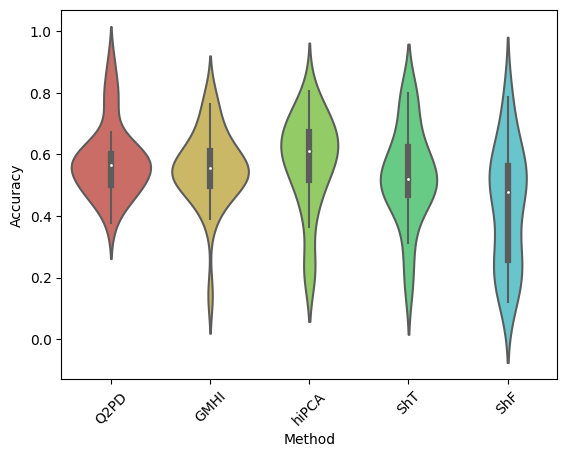

In [9]:
metrics_df = metrics_df.replace("Shannon Entropy", "ShT")
metrics_df = metrics_df.replace("Shannon Entropy on Functions", "ShF")

# overall accuracy

plt.figure()
sns.violinplot(metrics_df, x='Method', y='Accuracy', palette=palette)
plt.xticks(rotation=45)
plt.show()

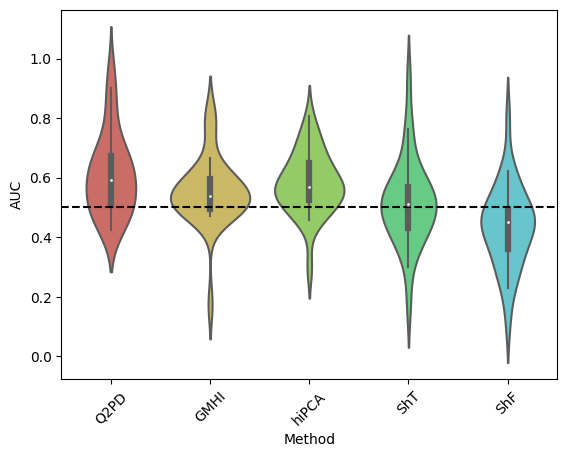

In [10]:
# overall AUC

plt.figure()
sns.violinplot(metrics_df, x='Method', y='AUC', palette=palette)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

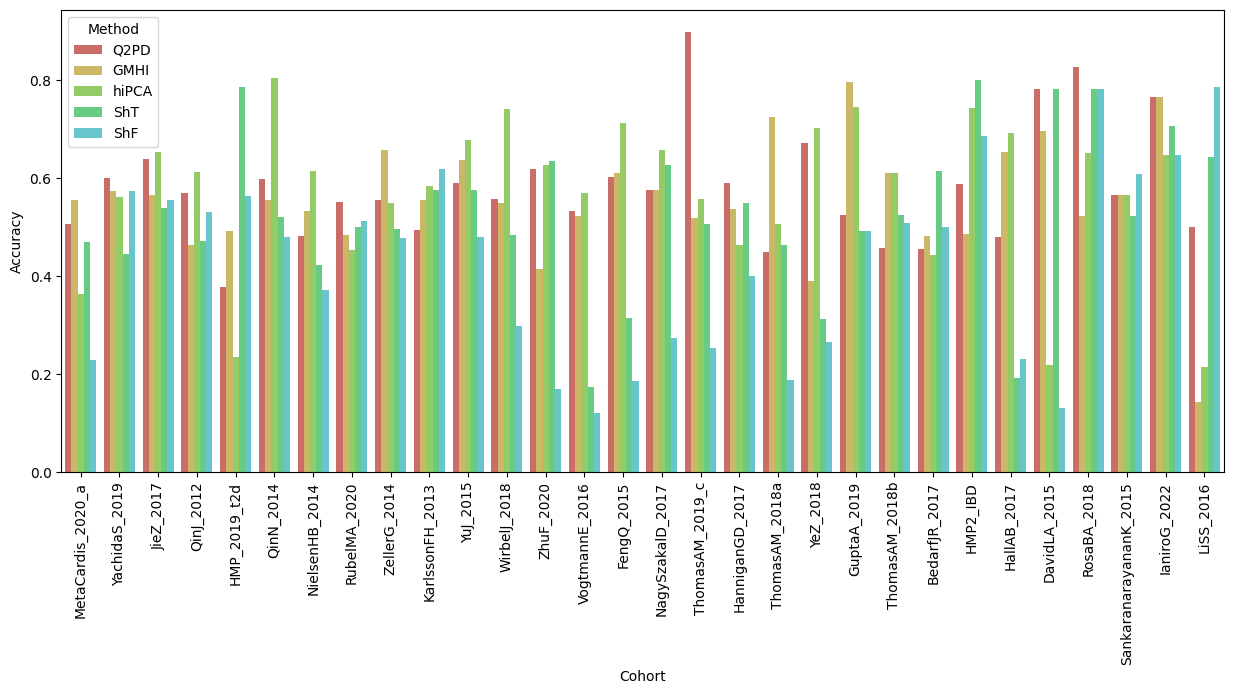

In [11]:
# accuracy per dataset

plt.figure(figsize=(15,6))
sns.barplot(metrics_df, hue='Method', y='Accuracy',x='Cohort', palette=palette)
plt.xticks(rotation=90)
plt.show()

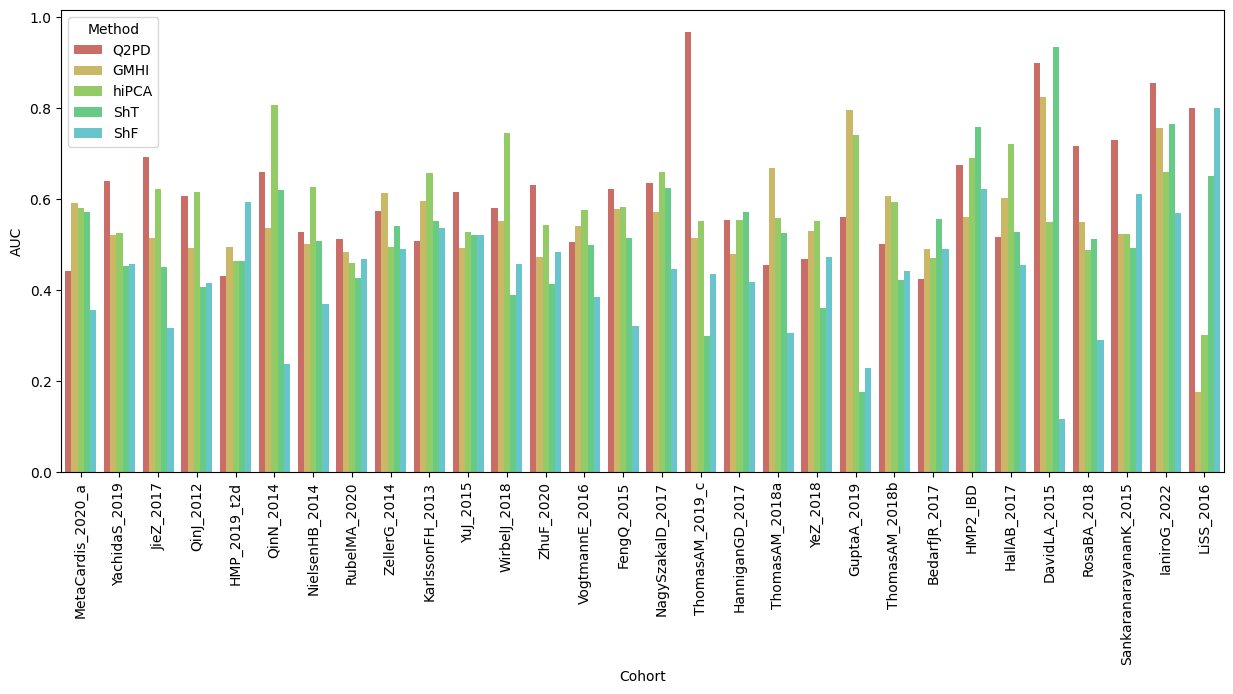

In [12]:
# AUC per dataset

plt.figure(figsize=(15,6))
sns.barplot(metrics_df, hue='Method', y='AUC',x='Cohort', palette=palette)
plt.xticks(rotation=90)
plt.show()

In [13]:
# for every disease, how do different methods score

meta_disease = pd.read_csv('Data/merged_metadata_diseases_matching.txt', sep="\t", header=None)
meta_disease.columns = ['Cohort','disease']

disease_list = []
for a in list(metrics_df['Cohort']):
    disease_list.append(list(meta_disease.loc[meta_disease['Cohort'] == a]['disease'])[0])

metrics_df['Disease'] = disease_list
print(metrics_df) 

                    Cohort  Accuracy       AUC Method Disease
0        MetaCardis_2020_a  0.506667  0.442228   Q2PD     mix
1            YachidaS_2019  0.600000  0.640608   Q2PD     CRC
2                JieZ_2017  0.638021  0.692022   Q2PD    ACVD
3                QinJ_2012  0.569061  0.606648   Q2PD     T2D
4             HMP_2019_t2d  0.378472  0.429830   Q2PD     T2D
..                     ...       ...       ...    ...     ...
25            IaniroG_2022  0.647059  0.569444    ShF     fmt
26                YeZ_2018  0.265625  0.472727    ShF      BD
27  SankaranarayananK_2015  0.608696  0.611111    ShF     T2D
28              FengQ_2015  0.185185  0.321147    ShF     CRC
29         KarlssonFH_2013  0.618056  0.537186    ShF     T2D

[150 rows x 5 columns]


In [14]:
# top AUC

highest_accuracy_rows = metrics_df.groupby("Cohort").apply(lambda x: x.nlargest(1, "AUC")).reset_index(drop=True)
disease_method_counts = pd.crosstab(highest_accuracy_rows["Disease"], highest_accuracy_rows["Method"])

# Display the resulting dataframe
#print(disease_method_counts)

# Step 1: Rank the methods within each disease based on counts
ranked_methods = disease_method_counts.rank(axis=1, method='average', ascending=False)

#print(ranked_methods)

# Step 2: Calculate the average rank for each method across diseases
average_rank = ranked_methods.mean(axis=0)

# Step 3: Sort the methods by their average rank (optional)
final_rank = average_rank.sort_values()

print("Average rank:")
# Display the final ranked methods
print(final_rank)

print('Number of wins:')
# Step 1: Identify the method with the highest count for each disease
# Use idxmax to find the method with the highest count in each disease
method_wins = disease_method_counts.idxmax(axis=1)

# Step 2: Count the occurrences of each method being the top-ranked
method_win_counts = method_wins.value_counts()

# Display the number of wins for each method
print(method_win_counts)

Average rank:
Method
Q2PD     2.392857
hiPCA    2.571429
ShT      3.142857
GMHI     3.321429
ShF      3.571429
dtype: float64
Number of wins:
Q2PD     6
hiPCA    5
ShT      2
GMHI     1
Name: count, dtype: int64


In [15]:
print(disease_method_counts.to_string())

Method           GMHI  Q2PD  ShF  ShT  hiPCA
Disease                                     
ACVD                0     1    0    0      0
BD                  0     0    0    0      1
CRC                 3     4    0    1      2
IBD                 0     0    0    1      2
PD                  0     0    0    1      0
T2D                 0     1    1    0      2
acute-diarrhoea     0     0    0    1      0
chronic-fatigue     0     0    0    0      1
cirrhosis           0     0    0    0      1
fmt                 0     1    0    0      0
infection           0     2    0    0      0
metabolic           0     1    0    0      0
mix                 2     0    0    0      0
schizophrenia       0     1    0    0      0


In [16]:
#print("Optimal threshold for health:")
#print(result_df['optimal_threshold'].mean())

Optimal threshold for health:


NameError: name 'result_df' is not defined

In [17]:
print(metrics_df.head())

              Cohort  Accuracy       AUC Method Disease
0  MetaCardis_2020_a  0.506667  0.442228   Q2PD     mix
1      YachidaS_2019  0.600000  0.640608   Q2PD     CRC
2          JieZ_2017  0.638021  0.692022   Q2PD    ACVD
3          QinJ_2012  0.569061  0.606648   Q2PD     T2D
4       HMP_2019_t2d  0.378472  0.429830   Q2PD     T2D


In [18]:
# Initialize the lists
wins = []
losses = []

df = metrics_df.copy()

# Group by 'cohort' to compare methods within each cohort
for cohort, group in df.groupby('Cohort'):
    # Get the AUC for the q2pd method and the highest AUC in the cohort
    q2pd_auc = group.loc[group['Method'] == 'Q2PD', 'AUC'].values[0]
    max_other_auc = group.loc[group['Method'] == 'hiPCA', 'AUC'].max()
    
    # Compare the q2pd_auc with the max_auc
    if q2pd_auc >= max_other_auc:
        # q2pd is the best or tied, add the difference to the wins list
        wins.append(q2pd_auc - max_other_auc)
    else:
        # Another method is better, add the difference to the losses list
        losses.append(max_other_auc - q2pd_auc)

# Output the results
print("Wins:", wins)
print("Losses:", losses)

print(np.mean(wins))
print(np.mean(losses))

Wins: [0.35, 0.03978494623655915, 0.19444444444444453, 0.06937923839332294, 0.5, 0.2277777777777778, 0.053316596194503296, 0.2063492063492064, 0.41506410256410275, 0.11588454790322977, 0.08678296865759905, 0.07964912280701753, 0.08710801393728218]
Losses: [0.04609279609279615, 0.1798850574712645, 0.0146520146520146, 0.033308611915723374, 0.20497835497835504, 0.00035714285714283367, 0.14955100161178914, 0.13713074246229157, 0.022653061224489845, 0.09926224010731044, 0.008884803921568873, 0.14677314914742068, 0.10324675324675325, 0.09158986175115202, 0.07068151147098511, 0.1654498044328554, 0.08522727272727265]
0.18658007425115736
0.09174848118065797


In [19]:
from scipy.stats import ttest_ind

# Calculate the t-test between wins and losses
t_stat, p_value = ttest_ind(wins, losses)

# Output the results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

T-statistic: 2.352
P-value: 0.026


In [20]:
wins = []
losses = []

# Group by 'cohort' to compare methods within each cohort
for cohort, group in df.groupby('Cohort'):
    # Get the AUC for the q2pd method and the highest AUC in the cohort
    q2pd_auc = group.loc[group['Method'] == 'Q2PD', 'AUC'].values[0]
    max_auc = group['AUC'].max()
    
    # Calculate the average AUC for other methods
    avg_other_auc = group.loc[group['Method'] != 'Q2PD', 'AUC'].mean()
    
    # Compare the q2pd_auc with the max_auc
    if q2pd_auc == max_auc:
        # q2pd is the best, add the difference to the wins list
        wins.append(q2pd_auc - avg_other_auc)
    else:
        # q2pd is not the best, add the difference to the losses list
        losses.append(max_auc - q2pd_auc)

# Output the results
print("Wins:", wins)
print("Losses:", losses)

print(np.mean(wins))
print(np.mean(losses))

Wins: [0.12249103942652328, 0.16666666666666674, 0.21605167064766773, 0.31875000000000003, 0.2569444444444444, 0.053349630021141736, 0.19246031746031744, 0.5170673076923078, 0.1515169767959078, 0.09931253696037845, 0.15239942983845428]
Losses: [0.13091422466422475, 0.033333333333333326, 0.23448275862068968, 0.08267922553636842, 0.1639741311354594, 0.20497835497835504, 0.01821428571428574, 0.14955100161178914, 0.14903640569669502, 0.022653061224489845, 0.09926224010731044, 0.008884803921568873, 0.14677314914742068, 0.21298701298701295, 0.10541474654377869, 0.07068151147098511, 0.1654498044328554, 0.08522727272727265, 0.04052631578947363]
0.204273638177619
0.11184334945491414


In [21]:
# Calculate the t-test between wins and losses
t_stat, p_value = ttest_ind(wins, losses)

# Output the results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

T-statistic: 2.596
P-value: 0.015


In [31]:
### calculate the winning margin for cohorts not included in the training of the GMHI

true_test_list = ['ZhuF_2020', 'HanniganGD_2017', 'MetaCardis_2020_a', 'ThomasAM_2018b', 'WirbelJ_2018', 'YachidaS_2019', 'ThomasAM_2019_c', 'RubelMA_2020', 'RosaBA_2018', 'QinJ_2012', 'NagySzakalD_2017', 'DavidLA_2015', 'BedarfJR_2017', 'ThomasAM_2018a', 'IaniroG_2022', 'YeZ_2018']

wins = []
losses = []

# Group by 'cohort' to compare methods within each cohort
for cohort, group in df.groupby('Cohort'):
    if cohort in true_test_list:
        # Get the AUC for the q2pd method and the highest AUC in the cohort
        q2pd_auc = group.loc[group['Method'] == 'Q2PD', 'AUC'].values[0]
        max_auc = group['AUC'].max()
        
        # Calculate the average AUC for other methods
        avg_other_auc = group.loc[group['Method'] != 'Q2PD', 'AUC'].mean()
        
        # Compare the q2pd_auc with the max_auc
        if q2pd_auc == max_auc:
            # q2pd is the best, add the difference to the wins list
            wins.append(q2pd_auc - avg_other_auc)
        else:
            # q2pd is not the best, add the difference to the losses list
            losses.append(max_auc - q2pd_auc)

# Output the results
print("Wins:", wins)
print("Losses:", losses)

print(np.mean(wins))
print(np.mean(losses))

# Calculate the t-test between wins and losses
t_stat, p_value = ttest_ind(wins, losses)

# Output the results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

Wins: [0.16666666666666674, 0.2569444444444444, 0.053349630021141736, 0.5170673076923078, 0.1515169767959078, 0.15239942983845428]
Losses: [0.13091422466422475, 0.033333333333333326, 0.01821428571428574, 0.14903640569669502, 0.022653061224489845, 0.008884803921568873, 0.21298701298701295, 0.10541474654377869, 0.1654498044328554, 0.08522727272727265]
0.2163240759098205
0.09321149512455174
T-statistic: 2.132
P-value: 0.051


In [24]:
print(metrics_df.groupby('Method')['Accuracy'].mean())
print(metrics_df.groupby('Method')['AUC'].mean())

Method
GMHI     0.554454
Q2PD     0.580013
ShF      0.430372
ShT      0.531042
hiPCA    0.572509
Name: Accuracy, dtype: float64
Method
GMHI     0.554233
Q2PD     0.610042
ShF      0.437088
ShT      0.516603
hiPCA    0.581181
Name: AUC, dtype: float64
